# Train RBM on first 6 months pandemic sequences

In [2]:
import os, sys
# put this at the very top of your entry script or notebook, before importing numpy/torch
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

pgm_path = 'PGM/'
if not os.path.isdir(pgm_path): # check if folder exists
    from git import Repo
    Repo.clone_from("https://github.com/jertubiana/PGM.git", pgm_path)
sys.path.append(pgm_path + 'source/')
sys.path.append(pgm_path + 'utilities/')

# sys.path.append('DNA_utils/')

In [3]:
# imports

import rbm, RBM_utils

import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from global_variables import *
%matplotlib inline
path = 'seq_data/'
# filename = 'rbd_aligned_sequences_no_gap_ref.fasta'
filename = 'rbd_aligned_sequences.fasta'

e:\ESCAPE_MAP_DRAFT\PGM/source\numba_utilities.py:1124: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 2, 'F', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  dmean_v_dw = np.dot(s1.T, V)
e:\ESCAPE_MAP_DRAFT\PGM/source\numba_utilities.py:961: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float32, 1, 'A', False, aligned=True), Array(float32, 2, 'A', False, aligned=True))
  mean_V = np.dot(weights, V) / sum_weights
C:\Users\maria\AppData\Roaming\Python\Python312\site-packages\Bio\pairwise2.py:278: BiopythonDeprecationWarning: Bio.pairwise2 has been deprecated, and we intend to remove it in a future release of Biopython. As an alternative, please consider using Bio.Align.PairwiseAligner as a replacement, and contact the Biopython developers if you still need the Bio.pairwise2 module.
  warnings.warn(


Loaded 29 KD vectors
Loaded 2 KD vectors
Loaded 671 KD vectors


In [4]:
import utilities, Proteins_utils, sequence_logo, plots_utils 
sequences = Proteins_utils.load_FASTA(path + filename) # Load protein sequences.
#shape
print('shape of sequences:', np.shape(sequences))
print('sequences:', sequences)



sequences=np.array(sequences)

shape of sequences: (2240, 178)
sequences: [[15 17 19 ... 17  1  5]
 [15 17 19 ... 17  1  5]
 [15 17 19 ... 17  1  5]
 ...
 [20 20 20 ... 17  7 16]
 [20 20 20 ... 17  7 16]
 [20 20 20 ... 17  7 16]]


In [5]:
WT_SEQ.shape

(178,)

In [6]:

#first row is WT
train_sequences=np.vstack([WT_SEQ, sequences])
print('Train sequences shape:', sequences.shape)


Train sequences shape: (2240, 178)


## Add pandemic sequences

In [7]:
import re
import numpy as np
import torch
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import Counter
FASTA = "seq_data/ns_mutated_spike_before_2020-07.fasta"  # headers: >{date}|{region}|{pango}

VOCS_NUM_before = Proteins_utils.load_FASTA(FASTA, drop_duplicates=False)  # numeric encoding of seqeunces




In [23]:

print(f"Total before 2020-07: {VOCS_NUM_before.shape}")
merged_seq = np.concatenate([VOCS_NUM_before, sequences], axis=0)
print(f"Merged shape: {merged_seq.shape}")


Total before 2020-07: (5050, 178)
Merged shape: (7290, 178)


## Train RBM 

In [24]:

# sequence_weights = 1.0/Proteins_utils.count_neighbours(train_sequences) # Compute sequence weights.
#uniform weights
sequence_weights = np.ones(merged_seq.shape[0])
#first seq should have higher weight

RBM_P = rbm.RBM(
              visible = 'Potts', # Categorical visible data.
              hidden = 'dReLU', # double ReLU hidden units.
              n_v = merged_seq.shape[-1], # Data dimension (here, number of columns in MSA)
              n_cv = 21, # Number of categories (here, 20 amino acids + 1 gap)
              n_h = 100 # Number of hidden units: 100
              ) # RBM object initialization.

RBM_P.fit(merged_seq, weights = sequence_weights, n_iter=50, N_MC=10,verbose=1, vverbose=1, l1b=0.12) # Fit by Persistent Contrastive Divergence for 500 epochs, 10 Monte Carlo steps; L_1^2 sparse regularization penalty = 0.1.
RBM_utils.saveRBM('RBM_pandemic.data',RBM_P)
print( RBM_P.likelihood(merged_seq).mean() ) # Evaluate partition function Z by Annealed Importance Sampling, then evaluate  sequences likelihood.



Iteration number 0, pseudo-likelihood: -0.79
Starting epoch 1
[RBM] Iteration 1, time = 4.80s, pseudo-likelihood = -3.06
Starting epoch 2
[RBM] Iteration 2, time = 4.82s, pseudo-likelihood = -5.51
Starting epoch 3
[RBM] Iteration 3, time = 5.01s, pseudo-likelihood = -9.02
Starting epoch 4
[RBM] Iteration 4, time = 4.71s, pseudo-likelihood = -12.01
Starting epoch 5
[RBM] Iteration 5, time = 4.52s, pseudo-likelihood = -14.53
Starting epoch 6
[RBM] Iteration 6, time = 4.68s, pseudo-likelihood = -16.92
Starting epoch 7
[RBM] Iteration 7, time = 4.69s, pseudo-likelihood = -18.50
Starting epoch 8
[RBM] Iteration 8, time = 5.04s, pseudo-likelihood = -23.46
Starting epoch 9
[RBM] Iteration 9, time = 5.03s, pseudo-likelihood = -27.02
Starting epoch 10
[RBM] Iteration 10, time = 5.01s, pseudo-likelihood = -24.16
Starting epoch 11
[RBM] Iteration 11, time = 4.79s, pseudo-likelihood = -28.41
Starting epoch 12
[RBM] Iteration 12, time = 5.39s, pseudo-likelihood = -30.70
Starting epoch 13
[RBM] Iter

In [25]:
RBM_P=RBM_utils.loadRBM('RBM_pandemic.data')


# Application to df bloom

# protein Expression

In [26]:
df_bloom=pd.read_csv('exp_data/starr_science/bloom_deep_scan_ACE2_with_sequence.csv')
df_bloom=df_bloom[df_bloom['site_SARS2']>=349] 
df_bloom=df_bloom[df_bloom['site_SARS2']<=526]
#reset index
df_bloom=df_bloom.reset_index(drop=True)
#sequence column to fasta file
with open('exp_data/starr_science/bloom_deep_scan_ACE2_with_sequence.fasta', 'w') as f:
    for index, row in df_bloom.iterrows():
        #if * in sequence, remove sequence
        if '*' in row['sequence']:
            continue
        f.write('>' + str(index) + '\n')
        f.write(row['sequence'] + '\n')
# df_bloom

In [27]:
df_bloom.shape

(3327, 13)

In [28]:
bloom_sequences=Proteins_utils.load_FASTA('exp_data/starr_science/bloom_deep_scan_ACE2_with_sequence.fasta')
print('shape of sequences:', np.shape(bloom_sequences))
bloom_sequences = [seq[BEGIN:-END] for seq in bloom_sequences]
bloom_sequences=np.array(bloom_sequences)
# bloom_sequences=one_hot_encode_matrix(bloom_sequences)
bloom_sequences.shape

shape of sequences: (3327, 201)


(3327, 178)

In [29]:
#onley keep site_SARS2 between 349 and 526

df_bloom

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg,sequence
0,19,349,S,A,S349A,S19A,-0.35,-0.32,-0.34,-1.37,-0.89,-1.13,NITNLCPFGEVFNATRFAAVYAWNRKRISNCVADYSVLYNSASFST...
1,19,349,S,C,S349C,S19C,0.00,-0.24,-0.12,-3.09,-0.97,-2.03,NITNLCPFGEVFNATRFACVYAWNRKRISNCVADYSVLYNSASFST...
2,19,349,S,D,S349D,S19D,-0.48,-0.52,-0.50,-1.06,-1.21,-1.14,NITNLCPFGEVFNATRFADVYAWNRKRISNCVADYSVLYNSASFST...
3,19,349,S,E,S349E,S19E,-1.08,-1.23,-1.15,-2.22,-2.04,-2.13,NITNLCPFGEVFNATRFAEVYAWNRKRISNCVADYSVLYNSASFST...
4,19,349,S,F,S349F,S19F,-1.96,-2.11,-2.03,-2.67,-2.33,-2.50,NITNLCPFGEVFNATRFAFVYAWNRKRISNCVADYSVLYNSASFST...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3322,196,526,G,R,G526R,G196R,-0.08,-0.08,-0.08,-0.19,-0.40,-0.30,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3323,196,526,G,S,G526S,G196S,0.00,-0.05,-0.02,-0.14,-0.13,-0.14,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3324,196,526,G,T,G526T,G196T,0.05,-0.04,0.01,-0.20,-0.11,-0.15,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
3325,196,526,G,V,G526V,G196V,-0.07,-0.02,-0.04,-0.12,-0.13,-0.12,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...


In [30]:

#for each sequence in df_bloom, compute likelihood
sequences_likelihood = RBM_P.likelihood(bloom_sequences)
df_bloom['likelihood'] = sequences_likelihood
#replace nan by -300
sequences_likelihood

Mismatch dimensions (100, 100), [10, 100], reinitializating I
Mismatch dimensions (100, 178, 21), [10, 178, 21], reinitializating I


array([-295799.3 , -295810.3 , -295801.03, ..., -295872.88, -295799.38,
       -295810.38], dtype=float32)

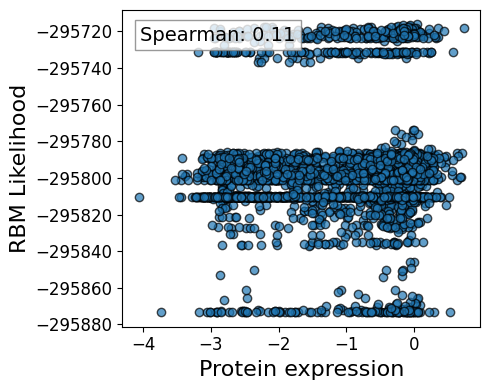

(0.10565438090352469, 1.0027277194419605e-09, -81778281465.34001)

In [31]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.metrics import r2_score

# Data
x = df_bloom['expr_avg']
y = df_bloom['likelihood']

# Metrics
spearman_corr, spearman_pval = stats.spearmanr(x, y)
r2 = r2_score(x, y)

# Plot
plt.figure(figsize=(5, 4))
plt.scatter(x, y, color='#1f77b4', alpha=0.7, edgecolor='black')

plt.xlabel('Protein expression', fontsize=16)
plt.ylabel('RBM Likelihood', fontsize=16)

# Stats box
plt.text(
    0.05, 0.95, f"Spearman: {spearman_corr:.2f}",
    transform=plt.gca().transAxes, fontsize=14, va='top',
    bbox=dict(facecolor='white', alpha=0.8, edgecolor='grey')
)

# Optional: highlight wildtype at (0, 0)
# plt.scatter(0, 0, color='red', marker='D', s=100, label='Wildtype')
# plt.annotate('Wildtype', xy=(0, 0), xytext=(-1, -0.2), fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

spearman_corr, spearman_pval, r2


# Grouping by site

In [32]:
WT_embe=Proteins_utils.load_FASTA('seq_data/rbd_wt.fasta')
WT_embe = [seq[BEGIN:-END] for seq in WT_embe]
WT_embe=np.array(WT_embe)
likelihood_WT = RBM_P.likelihood(WT_embe)
print('likelihood_WT:', likelihood_WT)

likelihood_WT: [-295714.44]


In [33]:
df_bloom['deltaE'] = -likelihood_WT+df_bloom['likelihood']
df_bloom

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg,sequence,likelihood,deltaE
0,19,349,S,A,S349A,S19A,-0.35,-0.32,-0.34,-1.37,-0.89,-1.13,NITNLCPFGEVFNATRFAAVYAWNRKRISNCVADYSVLYNSASFST...,-295799.31250,-84.87500
1,19,349,S,C,S349C,S19C,0.00,-0.24,-0.12,-3.09,-0.97,-2.03,NITNLCPFGEVFNATRFACVYAWNRKRISNCVADYSVLYNSASFST...,-295810.31250,-95.87500
2,19,349,S,D,S349D,S19D,-0.48,-0.52,-0.50,-1.06,-1.21,-1.14,NITNLCPFGEVFNATRFADVYAWNRKRISNCVADYSVLYNSASFST...,-295801.03125,-86.59375
3,19,349,S,E,S349E,S19E,-1.08,-1.23,-1.15,-2.22,-2.04,-2.13,NITNLCPFGEVFNATRFAEVYAWNRKRISNCVADYSVLYNSASFST...,-295793.09375,-78.65625
4,19,349,S,F,S349F,S19F,-1.96,-2.11,-2.03,-2.67,-2.33,-2.50,NITNLCPFGEVFNATRFAFVYAWNRKRISNCVADYSVLYNSASFST...,-295810.31250,-95.87500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3322,196,526,G,R,G526R,G196R,-0.08,-0.08,-0.08,-0.19,-0.40,-0.30,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,-295801.09375,-86.65625
3323,196,526,G,S,G526S,G196S,0.00,-0.05,-0.02,-0.14,-0.13,-0.14,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,-295789.50000,-75.06250
3324,196,526,G,T,G526T,G196T,0.05,-0.04,0.01,-0.20,-0.11,-0.15,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,-295872.87500,-158.43750
3325,196,526,G,V,G526V,G196V,-0.07,-0.02,-0.04,-0.12,-0.13,-0.12,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,-295799.37500,-84.93750


In [34]:
df_bloom_avg = df_bloom.groupby('site_SARS2').agg(lambda x: x.mean() if np.issubdtype(x.dtype, np.number) else x.iloc[0]).reset_index()



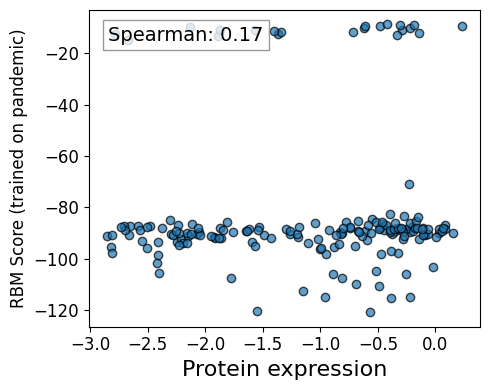

(0.16838612278161436, 0.024653376983095308, -9286.510833802053)

In [39]:
import scipy.stats as stats
from sklearn.metrics import r2_score

# Calculate Spearman correlation
spearman_corr, spearman_pval = stats.spearmanr(df_bloom_avg['expr_avg'], df_bloom_avg['deltaE'])

# Calculate R² score
r2 = r2_score(df_bloom_avg['expr_avg'], df_bloom_avg['deltaE'])

# Create figure
plt.figure(figsize=(5, 4))  # Slightly larger for readability

# Scatter plot with enhanced visualization
plt.scatter(df_bloom_avg['expr_avg'], df_bloom_avg['deltaE'], color='#1f77b4', alpha=0.7, edgecolor='black')

# Labels and title
plt.xlabel('Protein expression', fontsize=16)
plt.ylabel('RBM Score (trained on pandemic)', fontsize=12)
# plt.title(r'$\Delta E_{RBM}$ vs Expression Average', fontsize=16)

# Adding Spearman correlation in a small box inside the plot
textstr = f"Spearman: {spearman_corr:.2f}"
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
         fontsize=14, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.8, edgecolor='grey'))

# Grid and ticks
# plt.grid(True, linestyle='--', linewidth=0.6, alpha=0.6)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Removing top and right spines for a cleaner look
ax = plt.gca()



# Tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

# Print correlation and R² score
spearman_corr, spearman_pval, r2
